# Import

In [39]:
RUN_LOCAL = True 

if not RUN_LOCAL:
    !pip install grad-cam
    !pip install ttach

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib.pyplot import imshow

/home/amin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
"""
    check if gpu is available then put DEVICE to cuda:0,
    else DEVICE is equal to cpu.
"""

DEVICE = None

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

DEVICE = torch.device("cpu")
DEVICE

Running on the GPU


device(type='cpu')

# Config

In [40]:
%matplotlib inline

In [41]:
BATCH_SIZE = 32
DATA_LOADER_KWARGS = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 0,
}

RGB_MEANS = [0.485, 0.456, 0.406]
RGB_STD = [0.229, 0.224, 0.225]

# Data

Download data from this [link](https://drive.google.com/file/d/158VyFbTPLHE_uN2yXvMtalSqdD2mdd5r/view).

## Data Loaders

In [42]:
"""
Layers:
    resizing images to 256x256 pixels
    center croping images to 224x224 pixels
    converting to Tensor
    Normalize with RGB_MEANS and RBG_STD
"""

resize_transform = torchvision.transforms.Resize((256, 256))
center_crop_transform = torchvision.transforms.CenterCrop((224, 224))
convert_transform = torchvision.transforms.ToTensor()
normalize_transform = torchvision.transforms.Normalize(RGB_MEANS, RGB_STD)
transforms = [resize_transform, center_crop_transform, convert_transform, normalize_transform]
transform = torchvision.transforms.Compose(transforms)

transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [43]:
d_path = '.'
all_dataset = torchvision.datasets.ImageFolder(d_path, transform=transform)
data_len = len(all_dataset)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(all_dataset,[int(data_len*0.7), int(data_len*0.2), int(data_len*0.1)])

train_loader = DataLoader(train_dataset, **DATA_LOADER_KWARGS)
val_loader = DataLoader(val_dataset, **DATA_LOADER_KWARGS)
test_loader = DataLoader(test_dataset, **DATA_LOADER_KWARGS)

print('Train Classes Dist:', np.bincount(np.array(all_dataset.targets)[train_dataset.indices]))
print('Val Classes Dist:  ', np.bincount(np.array(all_dataset.targets)[val_dataset.indices]))
print('Test Classes Dist: ', np.bincount(np.array(all_dataset.targets)[test_dataset.indices]))

Train Classes Dist: [1043 1057]
Val Classes Dist:   [307 293]
Test Classes Dist:  [150 150]


In [44]:
input_shape = tuple(all_dataset[0][0].shape)
num_classes = len(all_dataset.classes)

print('Input Shape =', input_shape)
print('Num of Classes =', num_classes)

Input Shape = (3, 224, 224)
Num of Classes = 2


## Visualizing

In [45]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor normalized image of size (C, H, W).
        Returns:
            Tensor: UnNormalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unnormalize = UnNormalize(RGB_MEANS, RGB_STD)

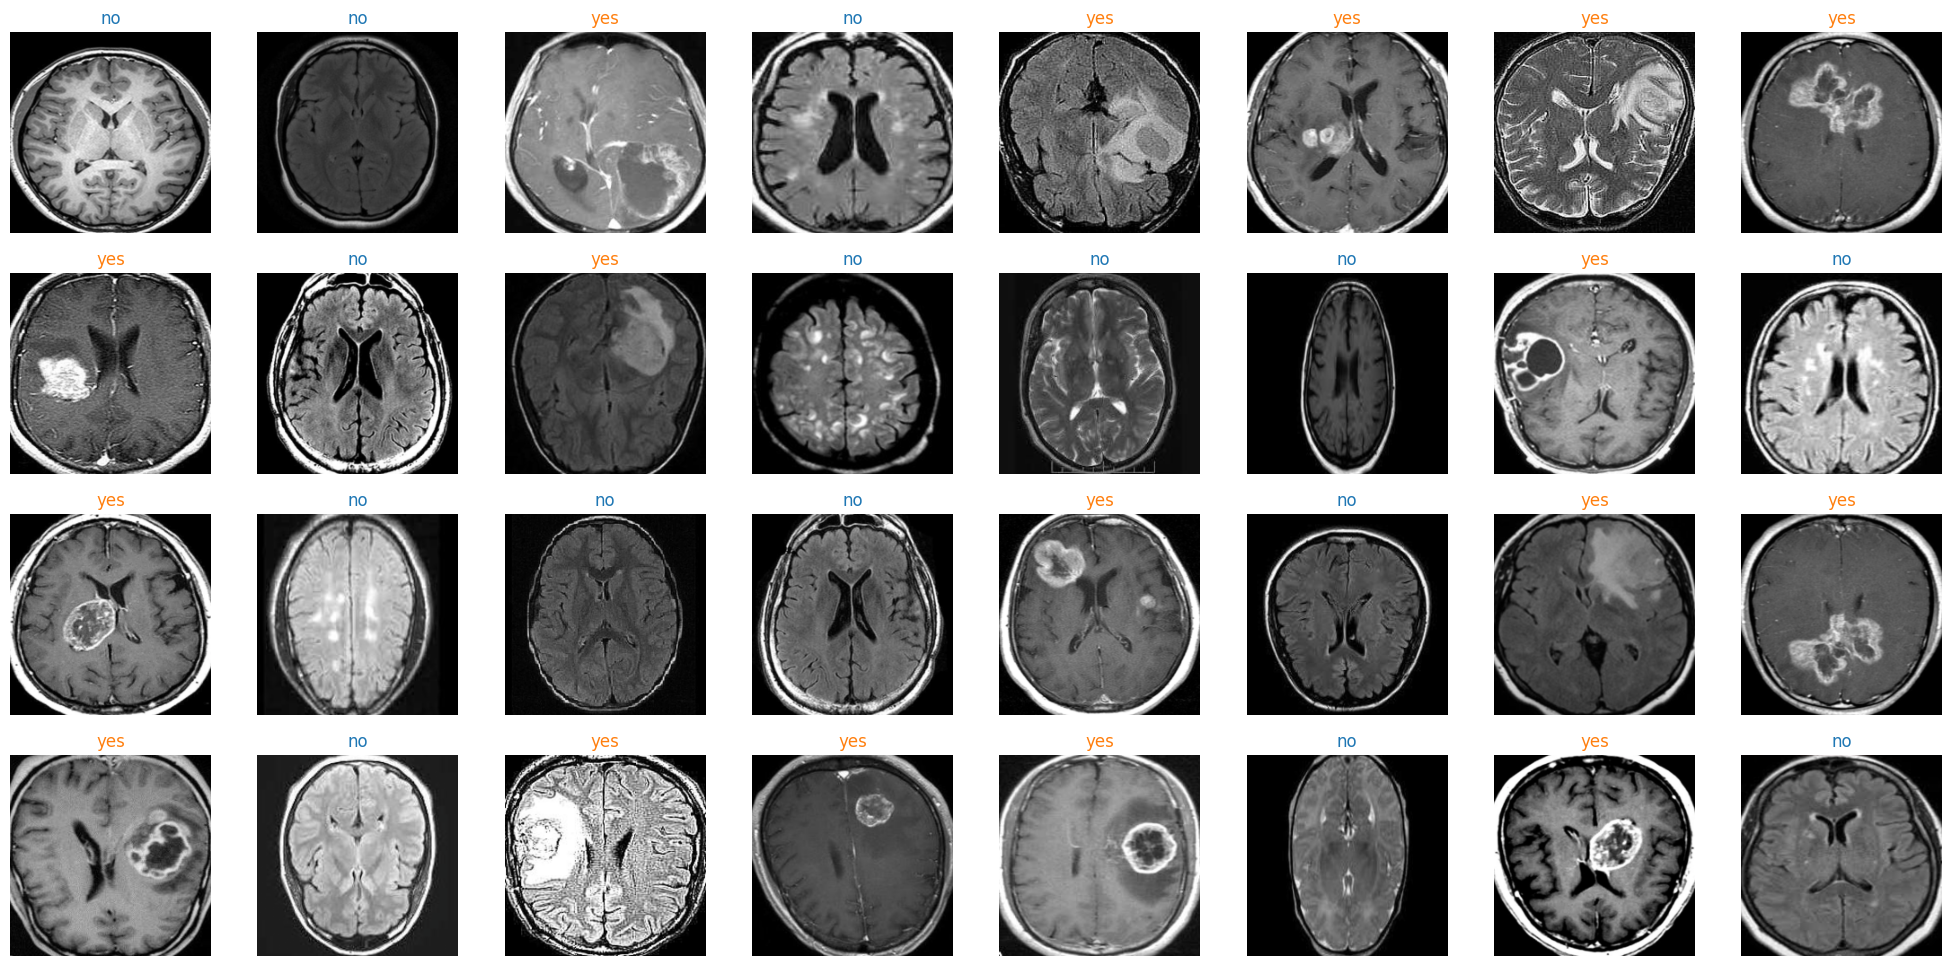

In [12]:
vis_num_images = 32
vis_images_per_row = 8

np.random.seed()
vis_image_indexes = np.random.choice(test_dataset.indices, size=vis_num_images, replace=False)
vis_images, vis_labels = [], []
for i in vis_image_indexes:
    new_image, new_label = all_dataset[i]
    vis_images.append(np.moveaxis(unnormalize(new_image).numpy(), 0, -1))
    vis_labels.append(new_label)

fig = plt.figure(figsize=(25, 12))
gs = fig.add_gridspec(int(np.ceil(vis_num_images / vis_images_per_row)), vis_images_per_row)

for i in range(vis_num_images):
    ax = fig.add_subplot(gs[i // vis_images_per_row, i % vis_images_per_row])
    ax.set_title(f'{all_dataset.classes[vis_labels[i]]}', c=f'C{vis_labels[i]}')
    ax.axis('off')
    ax.imshow(vis_images[i])

plt.show()

# Train & Test Methods

## Train

In [46]:
def train(model, train_loader, val_loader, optimizer, num_epochs=10):
    model = model.to(DEVICE)
    
    train_log = []
    test_log = []
    plt.figure(figsize=(16, 8))

    for epoch in range(1, num_epochs+1):
        train_loss = []
        model.train()

        for inputs, targets in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.get_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_log.append(np.mean(train_loss))

        test_loss = []
        model.eval()
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc='Validation', leave=False):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = model.get_loss(outputs, targets)
                test_loss.append(loss.item())

        test_log.append(np.mean(test_loss))

        plt.clf()
        plt.title(f'Epoch {epoch}/{num_epochs}')
        plt.plot(range(1, epoch+1), train_log, color='C0', label='Train')
        plt.plot(range(1, epoch+1), test_log, color='C1', label='Val')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    plt.close()

## Test

In [47]:
def test(model, data_loader):
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc='Predicting', leave=False):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            if type(outputs) is tuple: outputs = outputs[-1]
            outputs = outputs.detach().cpu().numpy()

            y_true += targets.detach().cpu().numpy().tolist()
            y_pred += np.argmax(outputs, axis=-1).tolist()

    print(classification_report(y_true, y_pred, target_names=all_dataset.classes))

# Model Definition

In [49]:
convs_costume1 = [
    (64, (3,3), (1,1), (1,1),False),
    (64, (3,3), (1,1), (1,1), False),
    (128, (3,3), (1,1), (1,1), False),
    (256, (3,3), (1,1), (1,1), False)
]

convs_costume2 = [
    (64, (3,3), (1,1), (1,1),False),
    (128, (3,3), (1,1), (1,1), False),
    (256, (3,3), (1,1), (1,1), False),
    (128, (3,3), (1,1), (1,1), False),
    (64, (3,3), (1,1), (1,1), False)
]

convs_costume3 = [
    (256, (3,3), (1,1), (1,1),False),
    (128, (3,3), (1,1), (1,1), False),
    (128, (3,3), (1,1), (1,1), False),
    (64, (3,3), (1,1), (1,1), False)
]

convs_costume4 = [
    (128, (3,3), (1,1), (1,1),False),
    (128, (3,3), (1,1), (1,1), True),
    (64, (3,3), (1,1), (1,1), False),
    (64, (3,3), (1,1), (1,1), True)
]

convs_costume5 = [
    (10, (3,3), (2,2), (0,0), False),
    (5, (3,3), (2,2), (1,1), True)
]

In [50]:
class ConvClassifier(nn.Module):
    def __init__(self, input_shape, num_classes, convs, fcs, conv_drop_rate=None, fc_drop_rate=None):

        super(ConvClassifier, self).__init__()


        self.conv_layers = None
        if convs == 'vgg16':
            vgg16_pretrained = torchvision.models.vgg16_bn(pretrained=True)
            self.conv_layers = vgg16_pretrained.features

        elif type(convs) is list:
            conv_layers = []
            last_channel_num = 3

            for conv_item in convs:
                out_channel_num, kernel_size, stride, padding, has_pooling = conv_item
                conv_layers.append(nn.Conv2d(in_channels=last_channel_num, out_channels=out_channel_num, kernel_size= kernel_size, stride = stride))
                conv_layers.append(nn.BatchNorm2d(out_channel_num))
                conv_layers.append(nn.ReLU())
                
                if not conv_drop_rate == None:
                    conv_layers.append(nn.Dropout(p=conv_drop_rate))
                if has_pooling:
                    conv_layers.append(nn.MaxPool2d(2,2))
                last_channel_num = out_channel_num

            self.conv_layers = nn.Sequential(*conv_layers)
            

            
        
        else:
            raise Exception(f'Wrong value for parameter `convs`: {convs}')
        

        
        convs_output_shape = self.conv_layers(torch.randn(1, *input_shape)).shape[1:]

        fc_layers = []
        fc_layers.append(nn.Flatten())
        last_layer_size = 1
        
        for val in convs_output_shape:
            last_layer_size *= val

        for fc_size in fcs:
            fc_layers.append(nn.Linear(last_layer_size, fc_size))
            fc_layers.append(nn.BatchNorm1d(fc_size))
            fc_layers.append(nn.ReLU())
            if not fc_drop_rate == None:
                fc_layers.append(nn.Dropout(p=fc_drop_rate))

            last_layer_size = fc_size

        fc_layers.append(nn.Linear(last_layer_size, num_classes))
        self.fc_layers = nn.Sequential(*fc_layers)
        self.cross_entropy = nn.CrossEntropyLoss()


    def forward(self, x):
        output = None
        output = self.conv_layers(x)
        output = self.fc_layers(output)
        return output

    def get_loss(self, outputs, targets):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, targets)
        return loss
            

## Create Model

## Costum args

## Model

In [52]:
num_classes = 2

convs = convs_costume5
# convs = "vgg16"

fcs = [32, 32, 10]
conv_drop_rate = 0.2
fc_drop_rate = 0.2
vgg16 = ConvClassifier(input_shape, num_classes, convs, fcs, conv_drop_rate, fc_drop_rate)

vgg16.to(DEVICE)
vgg16

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(10, 5, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3645, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, 

In [54]:
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-3)

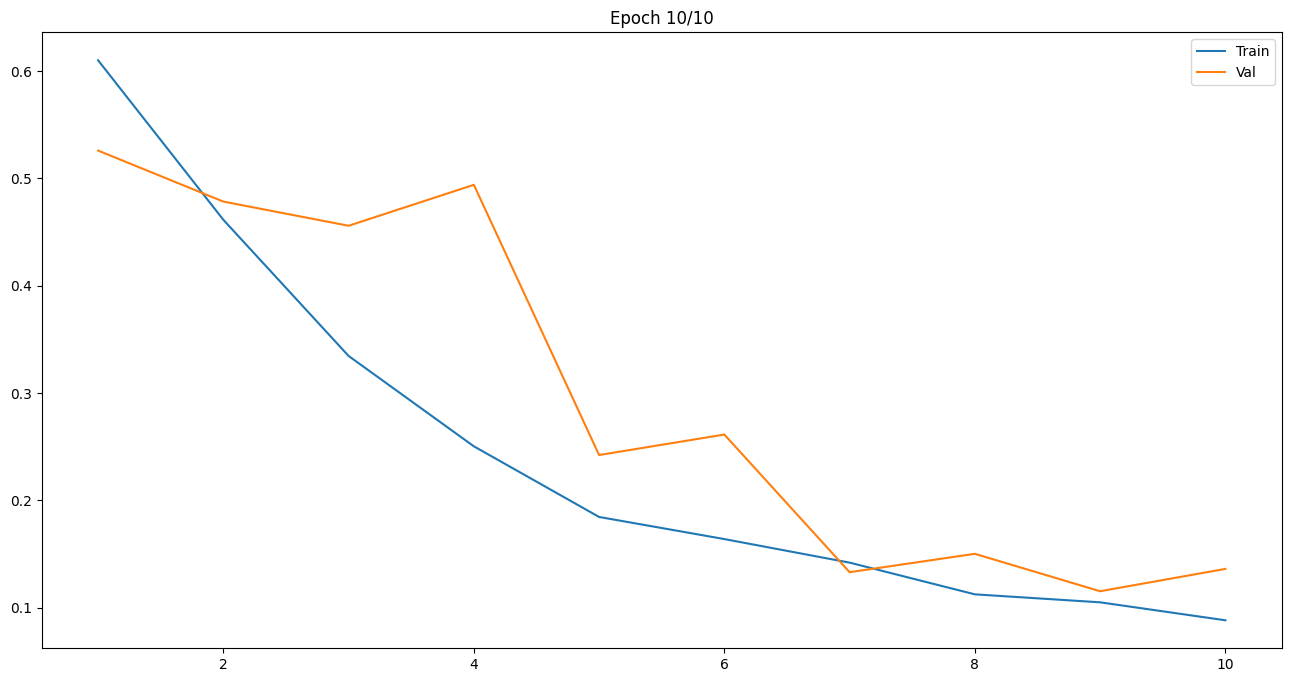

In [55]:
train(vgg16, train_loader, val_loader, optimizer, num_epochs=10)

## Test

In [56]:
test(vgg16, train_loader)

              precision    recall  f1-score   support

          no       0.99      0.98      0.98      1043
         yes       0.98      0.99      0.98      1057

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



In [57]:
test(vgg16, val_loader)

              precision    recall  f1-score   support

          no       0.92      0.96      0.94       307
         yes       0.95      0.91      0.93       293

    accuracy                           0.94       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.94      0.93       600



In [58]:
test(vgg16, test_loader)

              precision    recall  f1-score   support

          no       0.94      0.97      0.95       150
         yes       0.97      0.94      0.95       150

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



## CAM (Class Activation Map)

In [68]:
def CAM(model, target_layer):
    vis_num_images = 32
    vis_images_per_row = 8
    
    fig = plt.figure(figsize=(25, 12))
    gs = fig.add_gridspec(int(np.ceil(vis_num_images / vis_images_per_row)), vis_images_per_row)
    ########################## P10 #########################
    # Create the same grid of images as "Visualizing" part #
    # but you must add CAM overlay to them too. use        #
    # `GradCAMPlusPlus` and `show_cam_on_image` for this.  #
    ########################################################
    np.random.seed(6)
    vis_image_indexes = np.random.choice(test_dataset.indices, size=vis_num_images, replace=False)
    vis_images, vis_labels = [], []
    GCPP_datas = []
    grad_images = []

    GradCamPP = GradCAMPlusPlus(model=model, target_layers=target_layer)

    for i in vis_image_indexes:
        new_image, new_label = all_dataset[i]
        vis_images.append(np.moveaxis(unnormalize(new_image).numpy(), 0, -1))

        new_img_unsq = new_image.unsqueeze(0).to(DEVICE)
        grayscale_cam = GradCamPP(input_tensor = new_img_unsq)
        GCPP_datas.append(grayscale_cam.squeeze())
        grad_images.append(show_cam_on_image(vis_images[-1], GCPP_datas[-1]))
        vis_labels.append(new_label)

    for i in range(vis_num_images):
        ax = fig.add_subplot(gs[i // vis_images_per_row, i % vis_images_per_row])
        ax.set_title(f'{all_dataset.classes[vis_labels[i]]}', c=f'C{vis_labels[i]}')
        ax.axis('off')
        grad_images[i] = show_cam_on_image(vis_images[i], GCPP_datas[i])
        ax.imshow(grad_images[i])

    #done
    ########################## END #########################
    plt.show()

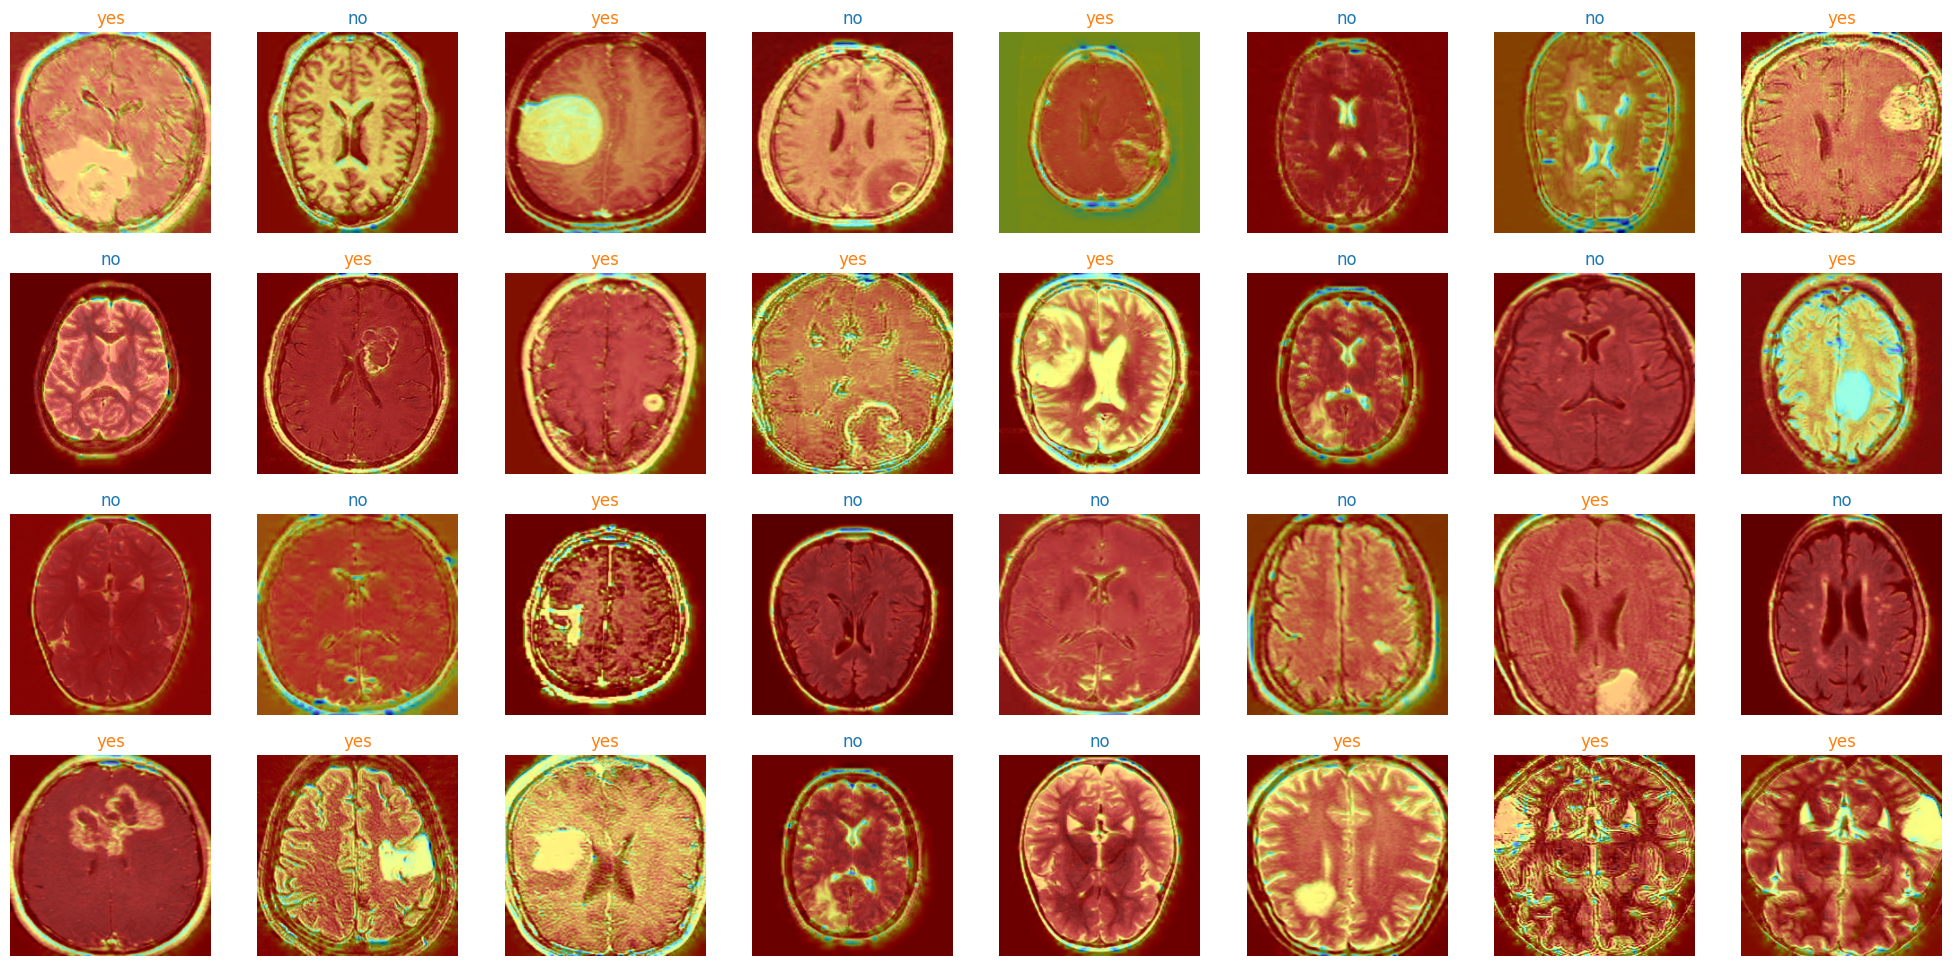

In [69]:
CAM(vgg16, vgg16.conv_layers)

# Transfer Learning

## Create Model

In [70]:
vgg16_imagenet = None
num_classes = 2
convs = 'vgg16'
fcs = [32, 32, 10]
conv_drop_rate = 0.2
fc_drop_rate = 0.2
vgg16_imagenet = ConvClassifier(input_shape, num_classes, convs, fcs, conv_drop_rate, fc_drop_rate)

vgg16_imagenet.to(DEVICE)
vgg16_imagenet

/home/amin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): C

## Train

In [71]:
optimizer = torch.optim.Adam(vgg16_imagenet.parameters(), lr=1e-2)


## P12 Answer:

In [72]:
train(vgg16_imagenet, train_loader, val_loader, optimizer, num_epochs=10)

KeyboardInterrupt: 

<Figure size 1600x800 with 0 Axes>

# Test

In [ ]:
test(vgg16_imagenet, train_loader)

In [ ]:
test(vgg16_imagenet, val_loader)

In [ ]:
test(vgg16_imagenet, test_loader)

## CAM (Class Activation Map)

In [ ]:
CAM(vgg16_imagenet, vgg16_imagenet.conv_layers[-1])